In [1]:
import os

In [2]:
os.chdir("../")
%pwd

'/Users/macbookpro/Documents/predict_publications/publications_prediction'

In [3]:
import pandas as pd

test_data = pd.read_csv('/Users/macbookpro/Documents/predict_publications/publications_prediction/data/test_data.csv')
train_data = pd.read_csv('/Users/macbookpro/Documents/predict_publications/publications_prediction/data/train_data.csv')
validation_data = pd.read_csv('/Users/macbookpro/Documents/predict_publications/publications_prediction/data/validation_data.csv')

In [4]:
# Convert 'timestamp' to a datetime format
train_data['date'] = pd.to_datetime(train_data['timestamp'], unit='s')

# Extracting the hour from the 'date' column
train_data['hour'] = train_data['date'].dt.hour

# Aggregate data based on 'hour', 'lon', and 'lat'
agg_columns = {
    'likescount': 'mean',
    'commentscount': 'mean',
    'symbols_cnt': 'mean',
    'words_cnt': 'mean',
    'hashtags_cnt': 'mean',
    'mentions_cnt': 'mean',
    'links_cnt': 'mean',
    'emoji_cnt': 'mean',
}

grouped_data = train_data.groupby(['timestamp', 'lon', 'lat', 'point', 'hour']).agg(agg_columns).reset_index()

grouped_data['publication_count'] = train_data.groupby(['timestamp', 'hour', 'lon', 'lat', 'point']).size().values
grouped_data.head()

,timestamp,lon,lat,point,hour,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt
0,1546300800,0.000000,0.000000,0101000020E61000000000000000000000000000000000...,0,31.666667,1.666667,51.333333,2.000000,2.000000,0.0,0.0,0.000000
1,1546300800,30.136232,60.000054,0101000020E6100000B8E59619E0223E40ABB649C80100...,0,52.000000,1.000000,28.000000,0.500000,2.000000,0.0,0.0,0.500000
2,1546300800,30.138478,59.835705,0101000020E610000077D0A94773233E4097654065F8EA...,0,32.000000,0.333333,46.000000,2.333333,3.000000,0.0,0.0,1.333333
3,1546300800,30.142969,60.023627,0101000020E6100000F5A5CFA399243E400B9A5B330603...,0,77.666667,3.333333,34.666667,2.666667,0.666667,0.0,0.0,1.666667
4,1546300800,30.142969,60.030359,0101000020E6100000F5A5CFA399243E40854A58CAE203...,0,19.000000,3.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [5]:
grouped_data['publication_count'] = train_data.groupby(['timestamp', 'hour', 'lon', 'lat', 'point']).size().values
grouped_data.head()

,timestamp,lon,lat,point,hour,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,publication_count
0,1546300800,0.000000,0.000000,0101000020E61000000000000000000000000000000000...,0,31.666667,1.666667,51.333333,2.000000,2.000000,0.0,0.0,0.000000,3
1,1546300800,30.136232,60.000054,0101000020E6100000B8E59619E0223E40ABB649C80100...,0,52.000000,1.000000,28.000000,0.500000,2.000000,0.0,0.0,0.500000,2
2,1546300800,30.138478,59.835705,0101000020E610000077D0A94773233E4097654065F8EA...,0,32.000000,0.333333,46.000000,2.333333,3.000000,0.0,0.0,1.333333,3
3,1546300800,30.142969,60.023627,0101000020E6100000F5A5CFA399243E400B9A5B330603...,0,77.666667,3.333333,34.666667,2.666667,0.666667,0.0,0.0,1.666667,3
4,1546300800,30.142969,60.030359,0101000020E6100000F5A5CFA399243E40854A58CAE203...,0,19.000000,3.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1


In [6]:
# Drop 'timestamp' as it's strongly correlated with other time features and may cause data leakage
X_train = grouped_data.drop(['publication_count', 'timestamp', 'point'], axis=1)
y_train = grouped_data['publication_count']

In [7]:
# Convert the 'hour' column to a datetime format
test_data['date'] = pd.to_datetime(test_data['hour'], unit='s')

# Drop the original 'hour' column which contains the timestamp
test_data.drop(columns=['hour'], inplace=True)

# Extract the datetime features from the 'date' column
test_data['hour'] = test_data['date'].dt.hour
test_data['day'] = test_data['date'].dt.day
test_data['dayofweek'] = test_data['date'].dt.dayofweek
test_data['month'] = test_data['date'].dt.month

# Drop the 'date' column as it's not needed for prediction
test_data.drop(columns=['date'], inplace=True)

# Set 'point' as the index for both datasets
train_data.set_index('point', inplace=True)
test_data.set_index('point', inplace=True)

# List of features to create in the test dataset
features_to_create = ['likescount', 'commentscount', 'symbols_cnt', 'words_cnt', 
                      'hashtags_cnt', 'mentions_cnt', 'links_cnt', 'emoji_cnt']

# Aggregate the training dataset based on 'point' and compute the median for each feature
aggregated_data = train_data[features_to_create].groupby('point').median()

# Merge the test dataset with the aggregated training data on 'point'
test_data = test_data.join(aggregated_data, on='point', how='left')

# Reset index for both datasets after the operations
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

X_test = test_data.drop(['sum', 'point', 'error'], axis=1)
y_test = test_data['sum']
X_test = X_test[X_train.columns]


# Modelling

In [8]:
from sklearn.preprocessing import MinMaxScaler
from numpy.lib.stride_tricks import as_strided
from keras.models import Sequential, clone_model, load_model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [9]:
def scale_data(X_train, X_test):
    """
    Scales the data using MinMaxScaler.
    
    Parameters:
    - X_train: Training data.
    - X_test: Test data.

    Returns:
    - X_train_scaled: Scaled training data.
    - X_test_scaled: Scaled test data.
    - scaler: The scaler used for transformation. Useful for inverse scaling.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

In [10]:
def create_windowed_dataset_2D(features, target, window_size):
    """
    Transforms the data into a windowed dataset.
    
    Parameters:
    - features: 2D numpy array where each row is a time step and columns are features.
    - target: 1D numpy array representing the target variable for each time step.
    - window_size: The size of the sliding window.
    
    Returns:
    - feature_windows: 3D numpy array of shape (samples, window_size, features).
    - target_windows: 2D numpy array of shape (samples, window_size).
    """
    num_windows = features.shape[0] - window_size
    feature_shape = (num_windows, window_size, features.shape[1])
    target_shape = (num_windows, window_size)
    
    feature_strides = (features.strides[0],) + features.strides
    target_strides = (target.strides[0],) + target.strides
    
    feature_windows = as_strided(features, shape=feature_shape, strides=feature_strides)
    target_windows = as_strided(target, shape=target_shape, strides=target_strides)
    
    return feature_windows, target_windows[:, -1]

In [11]:
def create_cnn_model(input_shape):
    """
    Constructs the CNN model for time series forecasting.

    Parameters:
    - input_shape: Tuple indicating the shape of an input sample.

    Returns:
    - model: Compiled CNN model.
    """
    model = Sequential()
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
    return model

In [12]:
def train_model(X_train, y_train, window_size):
    """
    Trains a CNN model using Time Series Cross-Validation.

    Parameters:
    - X_train: Training data.
    - y_train: Target variable for the training data.
    - window_size: The size of the sliding window.

    Returns:
    - best_cnn_model: The trained model with the lowest validation loss.
    """
    best_cnn_model = None
    lowest_val_loss = float('inf')

    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, val_index in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        model = create_cnn_model(input_shape=(window_size, X_train.shape[2]))

        checkpoint = ModelCheckpoint('best_cnn_model.h5', save_best_only=True, monitor='val_loss', mode='min')
        model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint], verbose=2, shuffle=False)
        
        val_loss = model.history.history['val_loss'][-1]
        if val_loss < lowest_val_loss:
            best_cnn_model = clone_model(model)
            best_cnn_model.load_weights('best_cnn_model.h5')
            best_cnn_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
            lowest_val_loss = val_loss

    return best_cnn_model

In [13]:
# 1. Scale the data
X_train_scaled, X_test_scaled, _ = scale_data(X_train, X_test)

# 2. Create windowed datasets
window_size = 10
X_train_windows, y_train_windows = create_windowed_dataset_2D(X_train_scaled, y_train.to_numpy(), window_size)
X_test_windows, y_test_windows = create_windowed_dataset_2D(X_test_scaled, y_test.to_numpy(), window_size)

# 3. Train the CNN model
best_cnn_model = train_model(X_train_windows, y_train_windows, window_size)

# 4. Evaluate the model
y_pred = best_cnn_model.predict(X_test_windows)


Epoch 1/10
18936/18936 - 51s - loss: 6.1919 - val_loss: 16.1689 - 51s/epoch - 3ms/step
Epoch 2/10


/Users/macbookpro/miniconda3/envs/predict_publications_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18936/18936 - 39s - loss: 6.0731 - val_loss: 15.8615 - 39s/epoch - 2ms/step
Epoch 3/10
18936/18936 - 22s - loss: 6.0400 - val_loss: 15.9526 - 22s/epoch - 1ms/step
Epoch 4/10
18936/18936 - 21s - loss: 6.0239 - val_loss: 15.8928 - 21s/epoch - 1ms/step
Epoch 5/10
18936/18936 - 21s - loss: 6.0104 - val_loss: 15.8419 - 21s/epoch - 1ms/step
Epoch 6/10
18936/18936 - 21s - loss: 5.9975 - val_loss: 15.8044 - 21s/epoch - 1ms/step
Epoch 7/10
18936/18936 - 21s - loss: 5.9699 - val_loss: 15.7443 - 21s/epoch - 1ms/step
Epoch 8/10
18936/18936 - 20s - loss: 5.9421 - val_loss: 15.6509 - 20s/epoch - 1ms/step
Epoch 9/10
18936/18936 - 20s - loss: 5.9122 - val_loss: 15.6025 - 20s/epoch - 1ms/step
Epoch 10/10
18936/18936 - 21s - loss: 5.8982 - val_loss: 15.7104 - 21s/epoch - 1ms/step


Epoch 1/10
37871/37871 - 64s - loss: 10.7228 - val_loss: 21.6542 - 64s/epoch - 2ms/step
Epoch 2/10
37871/37871 - 34s - loss: 10.5832 - val_loss: 21.4677 - 34s/epoch - 888us/step
Epoch 3/10
37871/37871 - 34s - loss: 10.5401 - val_loss: 21.3985 - 34s/epoch - 910us/step
Epoch 4/10
37871/37871 - 33s - loss: 10.5079 - val_loss: 21.3344 - 33s/epoch - 880us/step
Epoch 5/10
37871/37871 - 37s - loss: 10.4754 - val_loss: 21.2513 - 37s/epoch - 970us/step
Epoch 6/10
37871/37871 - 35s - loss: 10.4229 - val_loss: 21.2793 - 35s/epoch - 920us/step
Epoch 7/10
37871/37871 - 34s - loss: 10.3514 - val_loss: 20.9307 - 34s/epoch - 909us/step
Epoch 8/10
37871/37871 - 35s - loss: 10.2949 - val_loss: 20.8752 - 35s/epoch - 929us/step
Epoch 9/10
37871/37871 - 36s - loss: 10.2522 - val_loss: 20.8425 - 36s/epoch - 945us/step
Epoch 10/10
37871/37871 - 34s - loss: 10.2311 - val_loss: 20.8879 - 34s/epoch - 909us/step


Epoch 1/10
56806/56806 - 69s - loss: 14.2605 - val_loss: 15.3237 - 69s/epoch - 1ms/step
Epoch 2/10
56806/56806 - 114s - loss: 13.9900 - val_loss: 15.1487 - 114s/epoch - 2ms/step
Epoch 3/10
56806/56806 - 66s - loss: 13.9069 - val_loss: 15.1112 - 66s/epoch - 1ms/step
Epoch 4/10
56806/56806 - 47s - loss: 13.8605 - val_loss: 14.8850 - 47s/epoch - 831us/step
Epoch 5/10
56806/56806 - 50s - loss: 13.8296 - val_loss: 14.9604 - 50s/epoch - 884us/step
Epoch 6/10
56806/56806 - 49s - loss: 13.8207 - val_loss: 14.8816 - 49s/epoch - 855us/step
Epoch 7/10
56806/56806 - 49s - loss: 13.7987 - val_loss: 14.8490 - 49s/epoch - 870us/step
Epoch 8/10
56806/56806 - 50s - loss: 13.7844 - val_loss: 14.8528 - 50s/epoch - 879us/step
Epoch 9/10
56806/56806 - 55s - loss: 13.7644 - val_loss: 14.8488 - 55s/epoch - 974us/step
Epoch 10/10
56806/56806 - 80s - loss: 13.6919 - val_loss: 14.7438 - 80s/epoch - 1ms/step


Epoch 1/10
75741/75741 - 80s - loss: 14.4915 - val_loss: 18.4711 - 80s/epoch - 1ms/step
Epoch 2/10
75741/75741 - 53s - loss: 14.1902 - val_loss: 18.2076 - 53s/epoch - 705us/step
Epoch 3/10
75741/75741 - 86s - loss: 14.0864 - val_loss: 18.1929 - 86s/epoch - 1ms/step
Epoch 4/10
75741/75741 - 79s - loss: 14.0266 - val_loss: 18.1862 - 79s/epoch - 1ms/step
Epoch 5/10
75741/75741 - 73s - loss: 13.9983 - val_loss: 18.1303 - 73s/epoch - 966us/step
Epoch 6/10
75741/75741 - 88s - loss: 13.9701 - val_loss: 18.0869 - 88s/epoch - 1ms/step
Epoch 7/10
75741/75741 - 77s - loss: 13.9523 - val_loss: 18.1306 - 77s/epoch - 1ms/step
Epoch 8/10
75741/75741 - 60s - loss: 13.9038 - val_loss: 17.9939 - 60s/epoch - 796us/step
Epoch 9/10
75741/75741 - 61s - loss: 13.7984 - val_loss: 17.9403 - 61s/epoch - 802us/step
Epoch 10/10
75741/75741 - 64s - loss: 13.6264 - val_loss: 17.7494 - 64s/epoch - 843us/step


Epoch 1/10
94676/94676 - 98s - loss: 15.2023 - val_loss: 24.9728 - 98s/epoch - 1ms/step
Epoch 2/10
94676/94676 - 78s - loss: 14.8914 - val_loss: 24.5212 - 78s/epoch - 826us/step
Epoch 3/10
94676/94676 - 96s - loss: 14.7348 - val_loss: 24.4060 - 96s/epoch - 1ms/step
Epoch 4/10
94676/94676 - 72s - loss: 14.6582 - val_loss: 24.3194 - 72s/epoch - 762us/step
Epoch 5/10
94676/94676 - 73s - loss: 14.6078 - val_loss: 24.1879 - 73s/epoch - 766us/step
Epoch 6/10
94676/94676 - 76s - loss: 14.5674 - val_loss: 24.3966 - 76s/epoch - 802us/step
Epoch 7/10
94676/94676 - 80s - loss: 14.5336 - val_loss: 24.2374 - 80s/epoch - 840us/step
Epoch 8/10
94676/94676 - 89s - loss: 14.5156 - val_loss: 24.0441 - 89s/epoch - 937us/step
Epoch 9/10
94676/94676 - 73s - loss: 14.4997 - val_loss: 24.2954 - 73s/epoch - 770us/step
Epoch 10/10
94676/94676 - 101s - loss: 14.5047 - val_loss: 24.0275 - 101s/epoch - 1ms/step
22/22 [==============================] - 1s 584us/step


In [58]:
# Calculate the relative error
epsilon = 1e-10
errors = np.abs(y_pred.flatten() - y_test_windows) / (y_pred.flatten() + epsilon)
cnn_avg_relative_error = np.mean(errors)
print(f"Average Relative Error: {cnn_avg_relative_error}")

# Calculate RMSE
cnn_rmse = np.sqrt(mean_squared_error(y_test_windows, y_pred.flatten()))
print(f"RMSE on the validation set: {cnn_rmse}")


Average Relative Error: 2.3486863499384367
RMSE on the validation set: 9.30227485405286


In [54]:
def iterative_forecasting(model, initial_data, steps=672):
    """
    Perform iterative forecasting using the provided model.
    
    Parameters:
    - model: Trained Keras model.
    - initial_data: Input data for the first prediction (should be of shape (1, window_size, num_features)).
    - steps: Number of forecasting steps.
    
    Returns:
    - predictions: Array of predicted values.
    """
    predictions = []
    current_data = np.copy(initial_data)
    
    for step in range(steps):
        # Predict the next value using the current data
        next_prediction = model.predict(current_data)[0, 0]
        
        # Append the prediction to the results
        predictions.append(next_prediction)
        
        # Roll the current_data to remove the oldest observation and append the new prediction
        current_data = np.roll(current_data, shift=-1, axis=1)
        current_data[0, -1, 0] = next_prediction  # Assuming the target feature is the first feature
        
    return np.array(predictions)



In [55]:
# Get the last 'window_size' observations from the training data as the initial input
initial_input = X_train_windows[-1].reshape(1, window_size, X_train_scaled.shape[1])

# Forecast 28 days x 24 hours = 672 hours ahead
forecasted_values = iterative_forecasting(best_cnn_model, initial_input)

forecasted_values

1/1 [==============================] - 0s 8ms/step


array([1.6592188 , 1.6567829 , 1.6704657 , 1.7206728 , 1.6704657 ,
       1.7206728 , 1.5468776 , 1.8517907 , 1.9020163 , 1.3027998 ,
       1.8304353 , 1.3027998 , 1.381587  , 1.4416237 , 1.381587  ,
       1.4416237 , 2.010748  , 1.3855038 , 0.99825674, 1.3855038 ,
       0.99825674, 1.655749  , 1.747165  , 0.8581476 , 1.5850787 ,
       0.8581476 , 1.1801587 , 1.8107378 , 1.8557441 , 1.0245565 ,
       0.9799342 , 1.0245565 , 1.1046901 , 2.1797147 , 1.5156978 ,
       1.2840468 , 1.2224375 , 1.2840468 , 1.4077094 , 2.168239  ,
       1.7370484 , 0.9190097 , 1.3764844 , 1.1885657 , 1.3791156 ,
       2.2360673 , 1.7105113 , 1.3281518 , 0.8915976 , 1.3281518 ,
       1.3517731 , 1.8128988 , 1.3673162 , 1.0428345 , 1.3673162 ,
       1.0428345 , 1.6379249 , 1.9573776 , 1.1141677 , 0.9387598 ,
       1.1141677 , 1.1012522 , 1.839201  , 1.012413  , 1.2878168 ,
       1.012413  , 1.2878168 , 1.2556374 , 1.8153684 , 1.358696  ,
       1.1618702 , 1.358696  , 1.1203282 , 1.8569524 , 1.93547

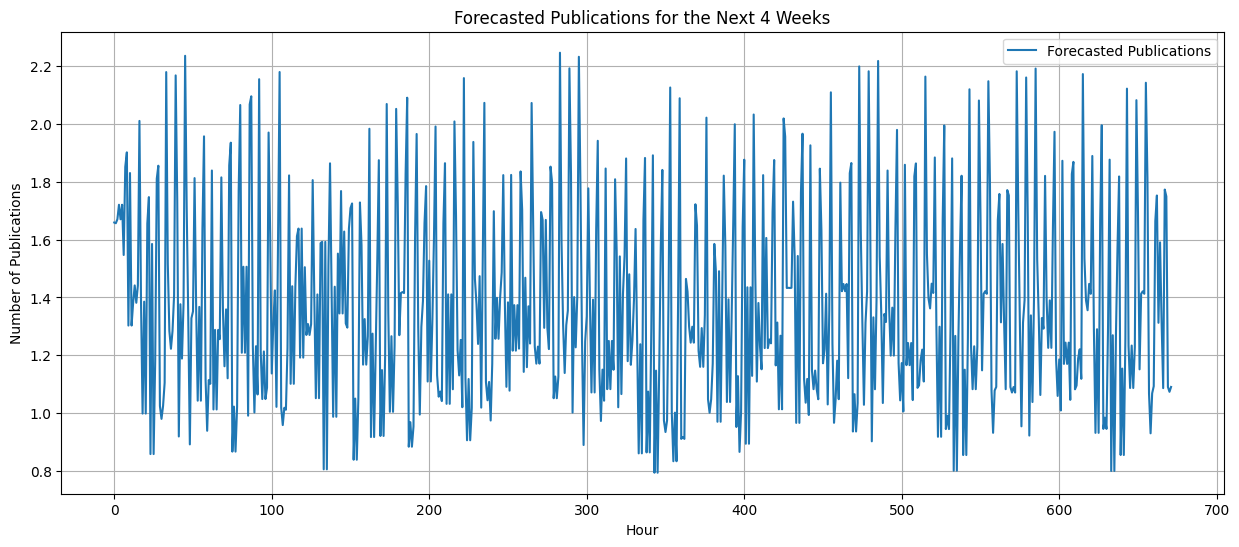

In [56]:
# Visualize the results
plt.figure(figsize=(15, 6))
plt.plot(forecasted_values, label="Forecasted Publications")
plt.title("Forecasted Publications for the Next 4 Weeks")
plt.xlabel("Hour")
plt.ylabel("Number of Publications")
plt.legend()
plt.grid(True)
plt.show()